In [3]:
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns

from simtk import unit
from openmmtools.constants import kB
temperature = 300.0 * unit.kelvin
kT = kB * temperature

import mdtraj as md

import random
import os
from pymbar import EXP

hartree_to_kT = ((1*unit.hartree).in_units_of(unit.joules)*unit.AVOGADRO_CONSTANT_NA / kT)

In [2]:
systems = ['tyk2','jnk1']

all_corrections = {x: {} for x in systems}
all_mm = {x: [] for x in systems}
new_results = {x: {} for x in systems}
n_bootstrap = 1000
folders = ['off120']


for c, target in enumerate(systems):
    color = sns.color_palette("hls", len(systems))[c]

    for folder in folders:
        outputs = {}
        ligands = []
        for d in os.listdir(f'../{target}/{folder}/'):
            if d[-3:] == '.pi':
                results = np.load(f'../{target}/{folder}/{d}',allow_pickle=True) 
                all_mm[target].append(results)
            else:
                pair = tuple([int(i) for i in d[3:].split('to')])
                outputs[pair] = d
                ligands.append(pair[0])
                ligands.append(pair[1])

        ligands = set(ligands)
        new_results[target] = {i:{} for i in ligands}
        oldnew = {0:'old',1:'new'}

        for ligand in ligands:
            for output in outputs.keys():
                if ligand in output:
                    endstate = oldnew[output.index(ligand)]
                    solventfile = f'../{target}/{folder}/{outputs[output]}/{endstate}_solvent.npy'
                    if os.path.exists(solventfile):
                        solvent = np.load(solventfile,allow_pickle=True).flatten()[0]
                        solvent['Epol']*hartree_to_kT
                        new_results[target][ligand][f'solvent-{outputs[output]}'] = solvent['Epol']*hartree_to_kT*0.59
                    complexfile = f'../{target}/{folder}/{outputs[output]}/{endstate}_complex.npy'
                    if os.path.exists(complexfile):
                        complex = np.load(complexfile,allow_pickle=True).flatten()[0]
                        new_results[target][ligand][f'complex-{outputs[output]}'] = complex['Epol']*hartree_to_kT*0.59           

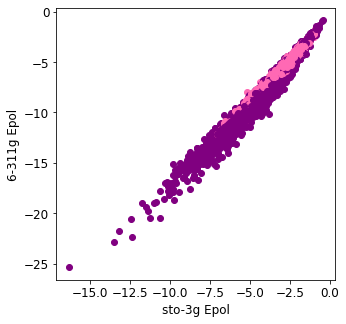

In [41]:

all_better_corrections = {x: {} for x in systems}
new_better_results = {x: {} for x in systems}
folders = ['off120-6-311']

plt.figure(figsize=(5,5))


for c, target in enumerate(systems):
    color = sns.color_palette("hls", len(systems))[c]

    for folder in folders:
        outputs = {}
        ligands = []
        for d in os.listdir(f'../{target}/{folder}/'):
            if d[-3:] == '.pi':
                results = np.load(f'../{target}/{folder}/{d}',allow_pickle=True) 
                all_mm[target].append(results)
            else:
                pair = tuple([int(i) for i in d[3:].split('to')])
                outputs[pair] = d
                ligands.append(pair[0])
                ligands.append(pair[1])

        ligands = set(ligands)
        new_better_results[target] = {i:{} for i in ligands}
        oldnew = {0:'old',1:'new'}
        for ligand in ligands:
            for output in outputs.keys():
                if ligand in output:
                    endstate = oldnew[output.index(ligand)]
                    all_solvent = []
                    all_complex = []
                    files = os.listdir(f'../{target}/{folder}/{outputs[output]}/')
                    files = [f for f in files if endstate in f and '-6-311g.npy' in f and 'solvent' in f]
                    for f in files:
                        solventfile = (f'../{target}/{folder}/{outputs[output]}/{f}')
                        if os.path.exists(solventfile):
                            solvent = np.load(solventfile,allow_pickle=True).flatten()[0]
                            val = solvent['Epol'][0]*hartree_to_kT*0.59
                            all_solvent.append(val)
                            index = int(f[11:-11])
                            plt.scatter(new_results[target][ligand][f'solvent-{outputs[output]}'][index],val,color='purple')
                    files = os.listdir(f'../{target}/{folder}/{outputs[output]}/')
                    files = [f for f in files if endstate in f and '-6-311g.npy' in f and 'complex' in f]
                    for f in files:
                        complexfile = (f'../{target}/{folder}/{outputs[output]}/{f}')
                        if os.path.exists(complexfile):
                            complex_ = np.load(complexfile,allow_pickle=True).flatten()[0]
                            val = complex_['Epol'][0]*hartree_to_kT*0.59
                            all_complex.append(val)    
                            index = int(f[11:-11])
                            plt.scatter(new_results[target][ligand][f'complex-{outputs[output]}'][index],val,color='hotpink')
                    if f'solvent-{outputs[output]}' not in new_better_results:
                        new_better_results[target][ligand][f'solvent-{outputs[output]}'] = []
                    if f'complex-{outputs[output]}' not in new_better_results:
                        new_better_results[target][ligand][f'complex-{outputs[output]}'] = []
                    new_better_results[target][ligand][f'solvent-{outputs[output]}'].extend(all_solvent)
                    new_better_results[target][ligand][f'complex-{outputs[output]}'].extend(all_complex)

plt.xlabel('sto-3g Epol')
plt.ylabel('6-311g Epol')
plt.show()

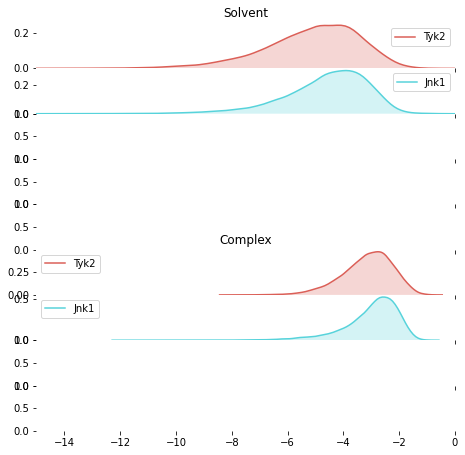

In [9]:
all_solvent = []
all_complex = []
bins = np.linspace(-16,0,100)
fig, axes = plt.subplots(ncols=1,nrows=9,figsize=(7.5,7.5),sharex=True)
for c,target in enumerate(new_results):
    color = sns.color_palette("hls", len(systems))[c]
    target_solvent = []
    target_complex = []
    for l in new_results[target].values():
        for thing in l.keys():
            if 'solvent' in thing:
                target_solvent.extend(l[thing])
            else:
                target_complex.extend(l[thing])
    sns.kdeplot(target_solvent,label=f'{target.capitalize()}',shade=True,color=color,ax=axes[0+c])
    sns.kdeplot(target_complex,label=f'{target.capitalize()}',shade=True,color=color,ax=axes[5+c])
    
axes[0].set_title('Solvent')
axes[5].set_title('Complex')
sns.despine(top=True, right=True, left=True, bottom=True)
plt.subplots_adjust(hspace=0.)
plt.xlim(-15,0)
plt.savefig('/Users/brucemah/Desktop/temp.pdf',transparent=True)
plt.show()

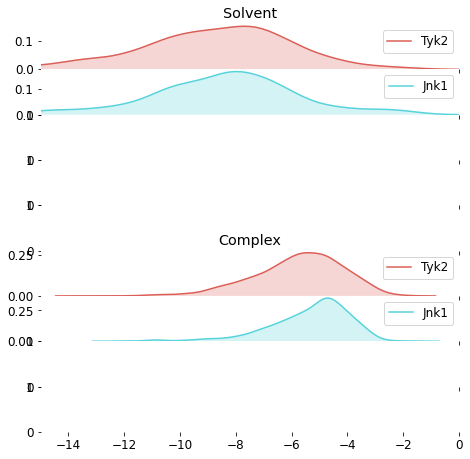

In [33]:
all_solvent = []
all_complex = []
bins = np.linspace(-16,0,100)
fig, axes = plt.subplots(ncols=1,nrows=9,figsize=(7.5,7.5),sharex=True)
for c,target in enumerate(new_better_results):
    color = sns.color_palette("hls", len(systems))[c]
    target_solvent = []
    target_complex = []
    for l in new_better_results[target].values():
        for thing in l.keys():
            if 'solvent' in thing:
                target_solvent.extend(l[thing])
            else:
                target_complex.extend(l[thing])
    sns.kdeplot(target_solvent,label=f'{target.capitalize()}',shade=True,color=color,ax=axes[0+c])
    sns.kdeplot(target_complex,label=f'{target.capitalize()}',shade=True,color=color,ax=axes[5+c])
    
axes[0].set_title('Solvent')
axes[5].set_title('Complex')
sns.despine(top=True, right=True, left=True, bottom=True)
plt.subplots_adjust(hspace=0.)
plt.xlim(-15,0)
plt.savefig('/Users/brucemah/Desktop/temp.pdf',transparent=True)
plt.show()

Correction is 2.16 (0.09) kcal/mol for ligand 0


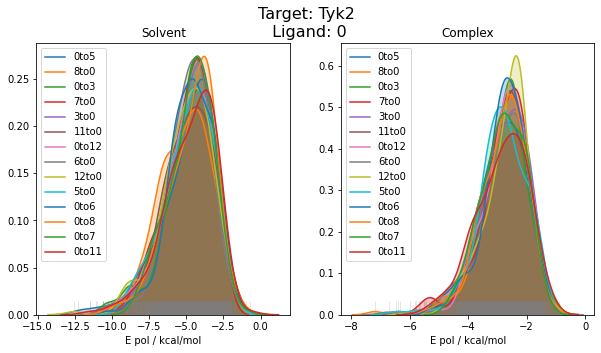

Correction is 3.06 (0.25) kcal/mol for ligand 1


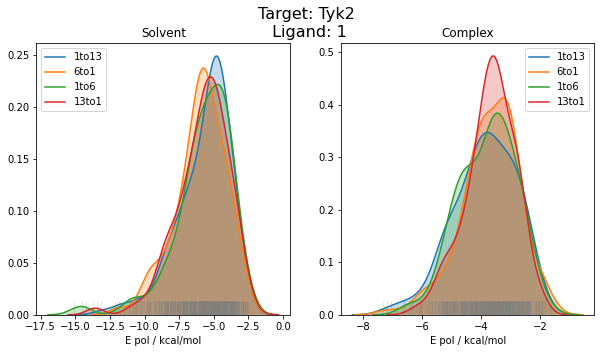

Correction is 3.10 (0.46) kcal/mol for ligand 2


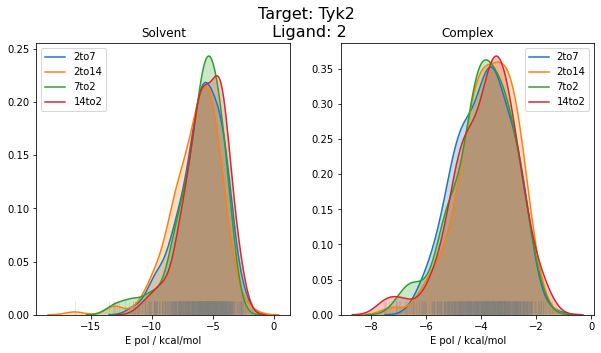

Correction is 1.89 (0.07) kcal/mol for ligand 3


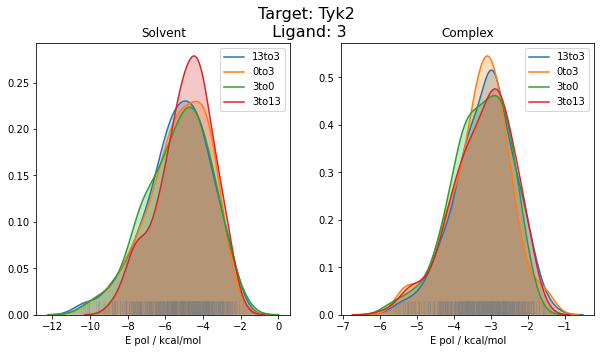

Correction is 1.92 (0.08) kcal/mol for ligand 4


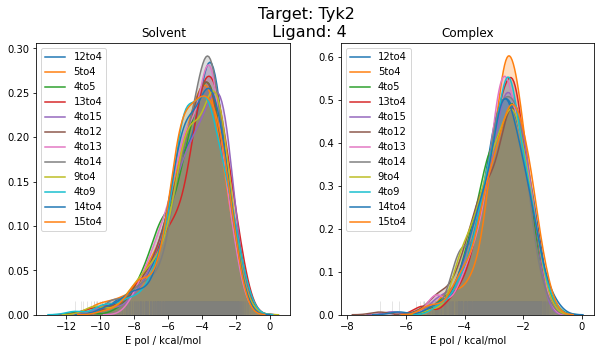

Correction is 2.90 (0.30) kcal/mol for ligand 5


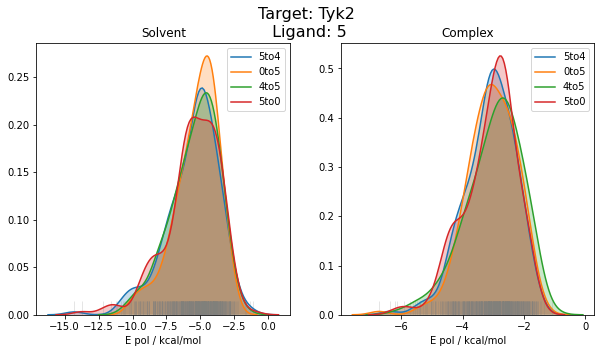

Correction is 2.90 (0.30) kcal/mol for ligand 6


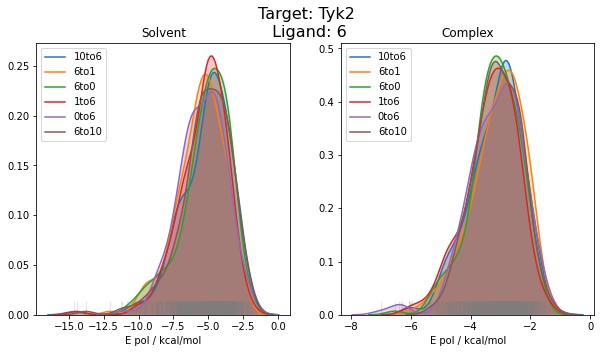

Correction is 2.88 (0.44) kcal/mol for ligand 7


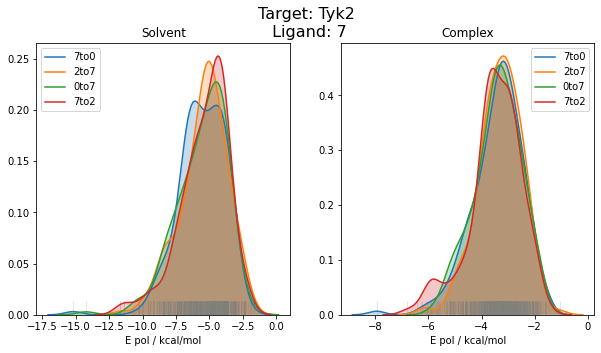

Correction is 2.85 (0.33) kcal/mol for ligand 8


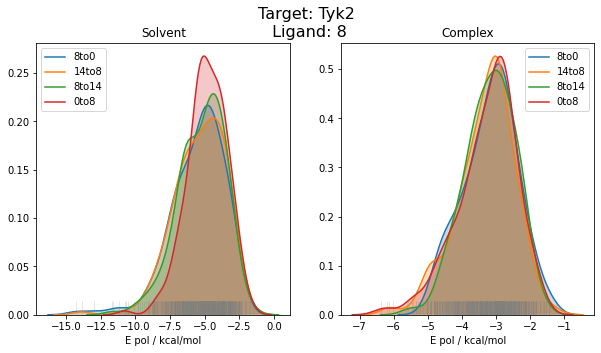

Correction is 2.39 (0.25) kcal/mol for ligand 9


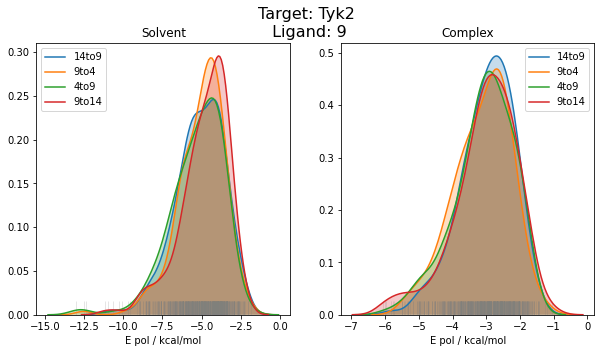

Correction is 3.28 (0.37) kcal/mol for ligand 10


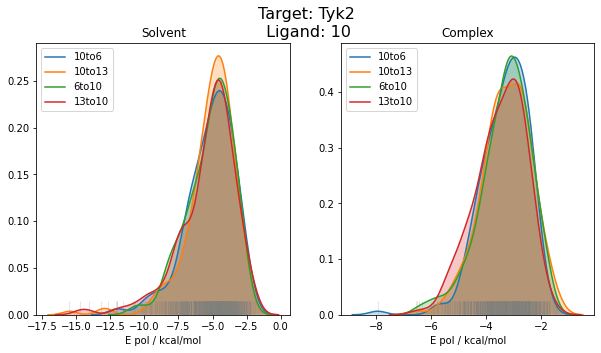

Correction is 2.24 (0.11) kcal/mol for ligand 11


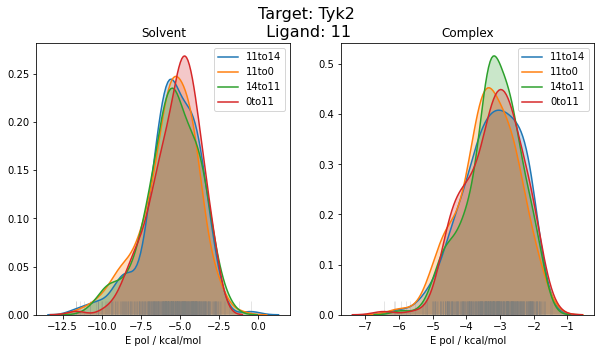

Correction is 2.17 (0.13) kcal/mol for ligand 12


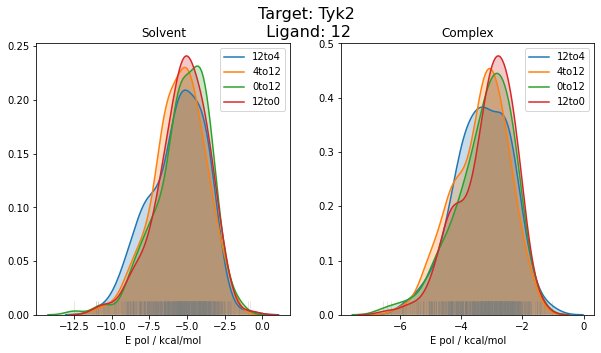

Correction is 3.49 (1.01) kcal/mol for ligand 13


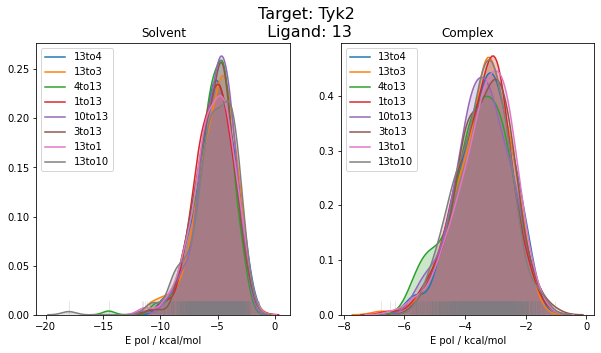

Correction is 2.52 (0.11) kcal/mol for ligand 14


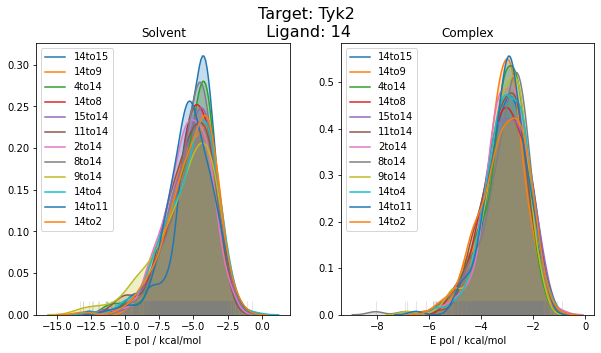

Correction is 2.52 (0.15) kcal/mol for ligand 15


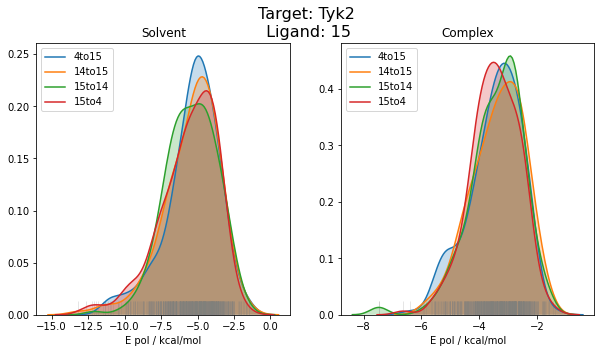

Correction is 1.38 (0.12) kcal/mol for ligand 0


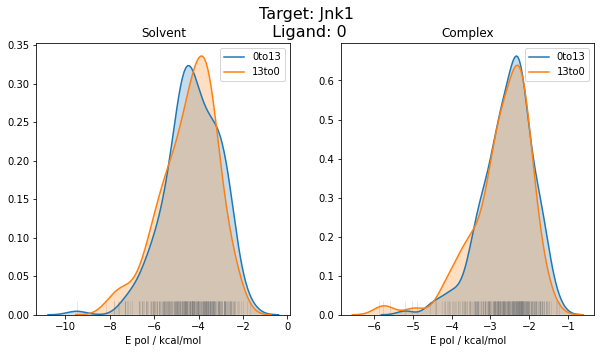

Correction is 1.68 (0.13) kcal/mol for ligand 1


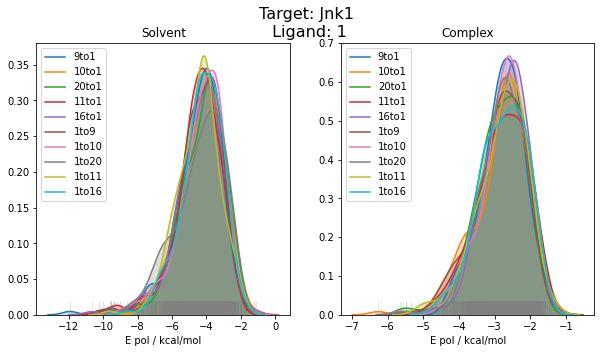

Correction is 1.85 (0.25) kcal/mol for ligand 2


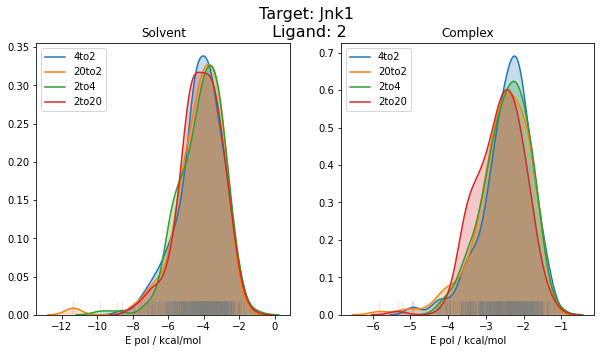

Correction is 1.46 (0.15) kcal/mol for ligand 3


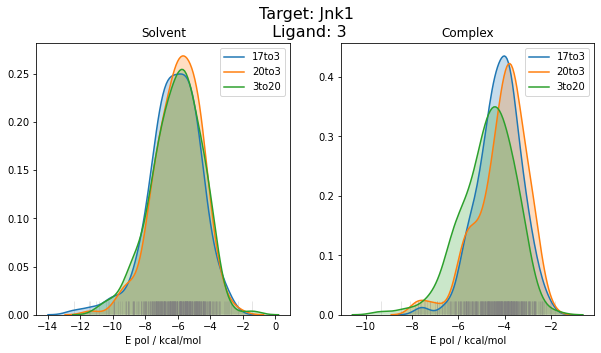

Correction is 1.92 (0.37) kcal/mol for ligand 4


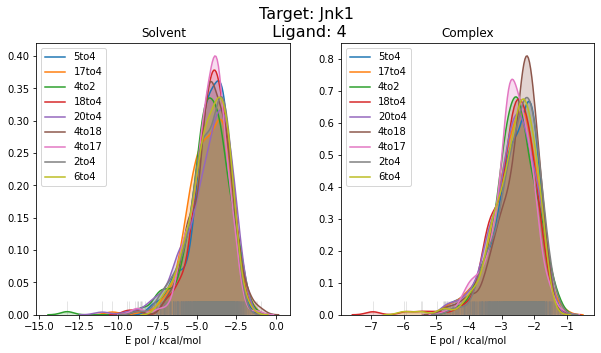

Correction is 1.83 (0.46) kcal/mol for ligand 5


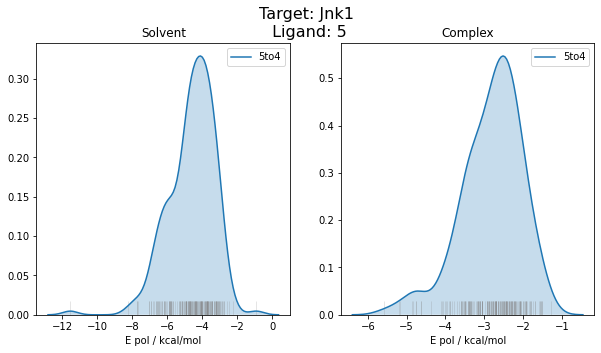

Correction is 1.36 (0.10) kcal/mol for ligand 6


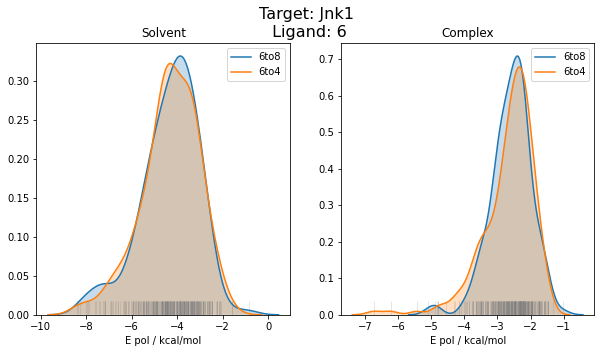

Correction is 1.70 (0.14) kcal/mol for ligand 8


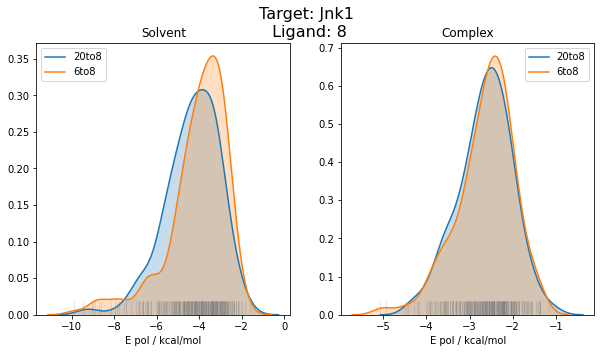

Correction is 1.34 (0.07) kcal/mol for ligand 9


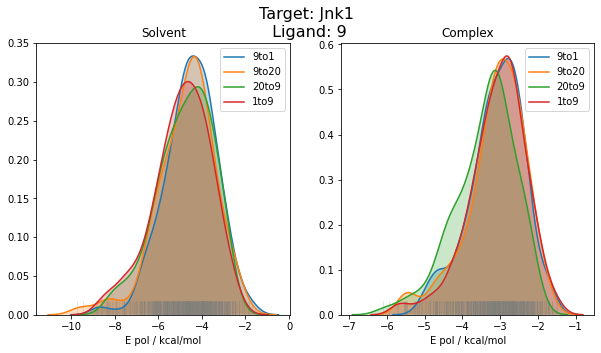

Correction is 1.45 (0.10) kcal/mol for ligand 10


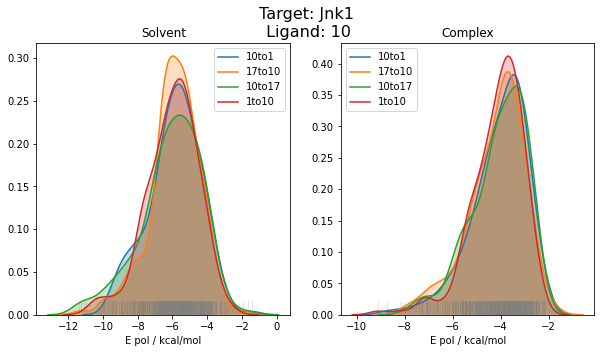

Correction is 1.36 (0.28) kcal/mol for ligand 11


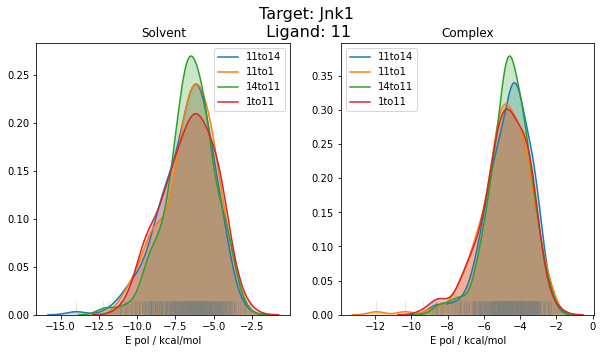

Correction is 1.84 (0.18) kcal/mol for ligand 12


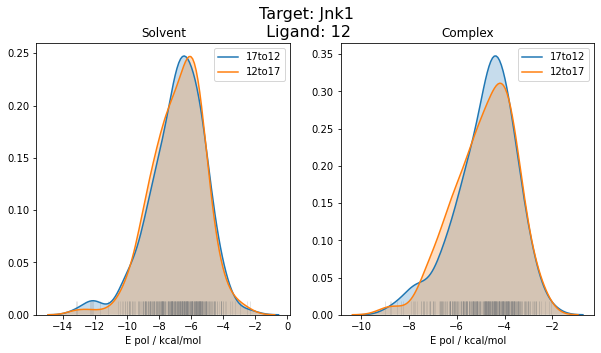

Correction is 2.62 (0.44) kcal/mol for ligand 13


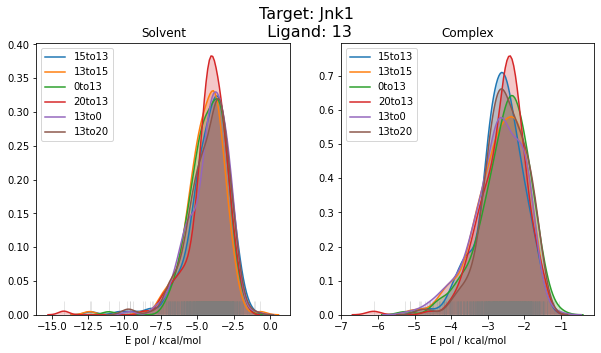

Correction is 1.85 (0.20) kcal/mol for ligand 14


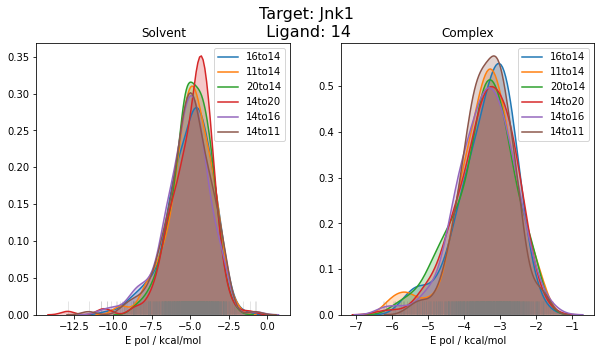

Correction is 2.43 (0.47) kcal/mol for ligand 15


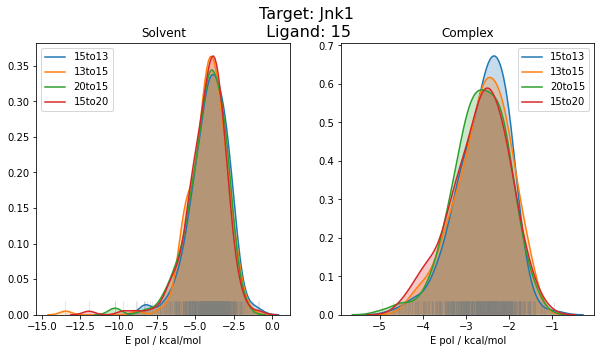

Correction is 1.55 (0.14) kcal/mol for ligand 16


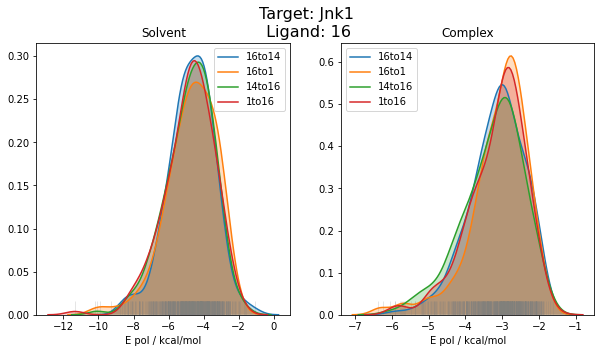

Correction is 2.02 (0.36) kcal/mol for ligand 17


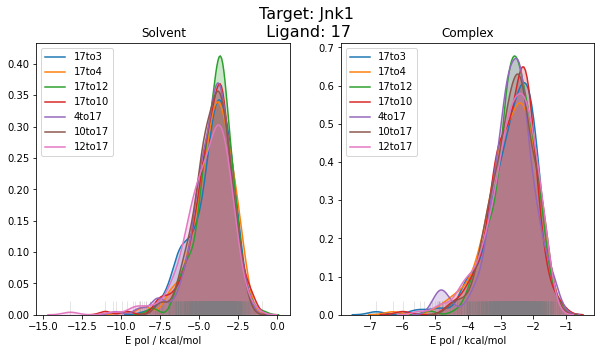

Correction is 2.81 (0.64) kcal/mol for ligand 18


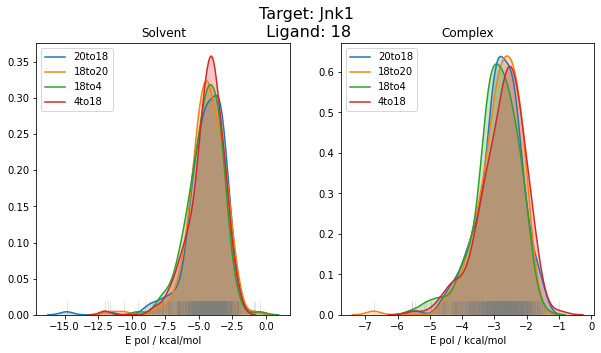

Correction is 1.74 (0.17) kcal/mol for ligand 20


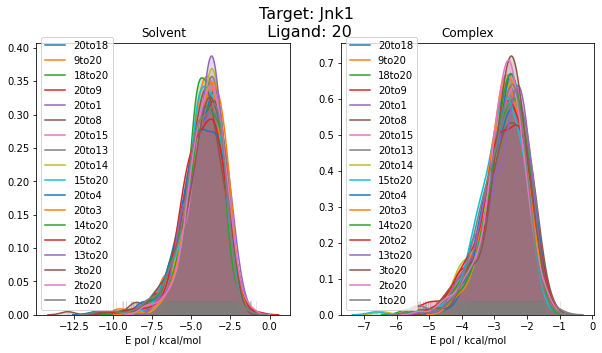

In [5]:

for c, target in enumerate(systems):
    color = sns.color_palette("hls", len(systems))[c]

    for ligand in new_results[target].keys():
        if len(new_results[target][ligand]) > 0:
            new_solvent_for_lig = []
            new_complex_for_lig = []
            fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(10,5))
            for thing in new_results[target][ligand]:
                if 'solvent' in thing:
                    Epol = new_results[target][ligand][thing]
                    if len(Epol) != 200:
                        print(ligand)
                        continue
                    sns.kdeplot(Epol,label=thing.split('-lig')[1],shade=True,ax=axes[0])
                    sns.rugplot(Epol,ax=axes[0],alpha=0.2,color='grey')
                    new_solvent_for_lig.extend(Epol)
                elif 'complex' in thing:
                    Epol = new_results[target][ligand][thing]
                    if len(Epol) != 200:
                        print(ligand)
                        continue
                    sns.kdeplot(Epol,label=thing.split('-lig')[1],shade=True,ax=axes[1])
                    sns.rugplot(Epol,ax=axes[1],alpha=0.2,color='grey')
                    new_complex_for_lig.extend(Epol)


            if len(new_solvent_for_lig) > 0 and len(new_complex_for_lig) > 0:
                bootstraps = []

                for _ in range(n_bootstrap):
                    comp = random.choices(new_complex_for_lig, k=len(new_complex_for_lig))
                    sol = random.choices(new_solvent_for_lig, k=len(new_solvent_for_lig))
                    corr_comp, err_comp = EXP(np.asarray(comp))
                    corr_sol, err_sol = EXP(np.asarray(sol))
                    bootstraps.append((corr_comp - corr_sol)*0.593)
                print(f'Correction is {np.mean(bootstraps):.2f} ({np.std(bootstraps):.2f}) kcal/mol for ligand {ligand}')
                all_corrections[target][ligand] = (np.mean(bootstraps), np.std(bootstraps))
            axes[0].set_title('Solvent')
            axes[1].set_title('Complex')
            axes[0].set_xlabel('E pol / kcal/mol')
            axes[1].set_xlabel('E pol / kcal/mol')
            fig.suptitle(f"Target: {target.capitalize()}\n Ligand: {ligand}", fontsize=16)
            plt.show()

0
Correction is 4.05 (0.55) kcal/mol for ligand 0


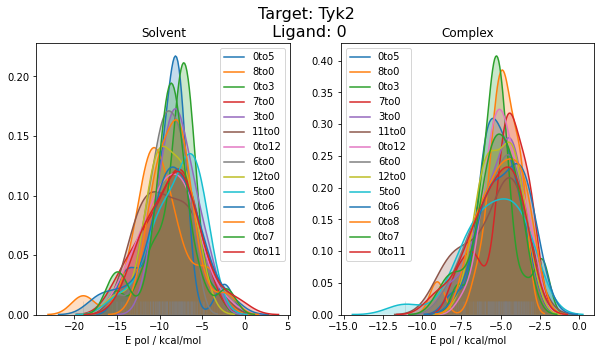

1
Correction is 2.18 (0.54) kcal/mol for ligand 1


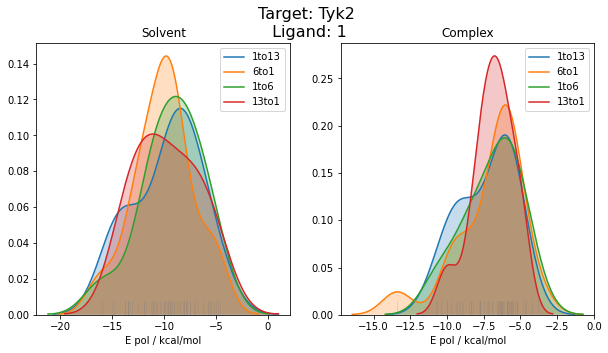

2
Correction is 6.75 (1.52) kcal/mol for ligand 2


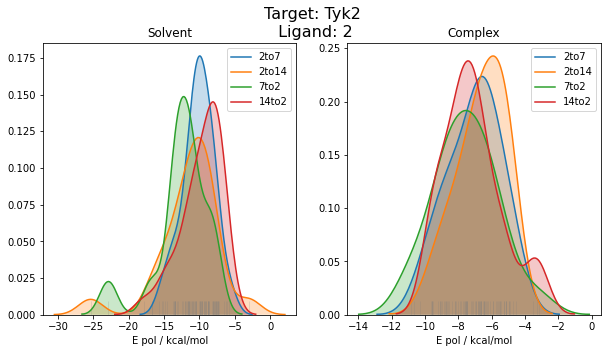

3
Correction is 3.47 (0.42) kcal/mol for ligand 3


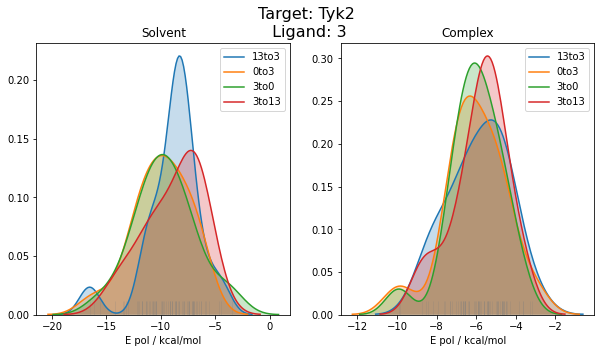

4
Correction is 2.61 (0.27) kcal/mol for ligand 4


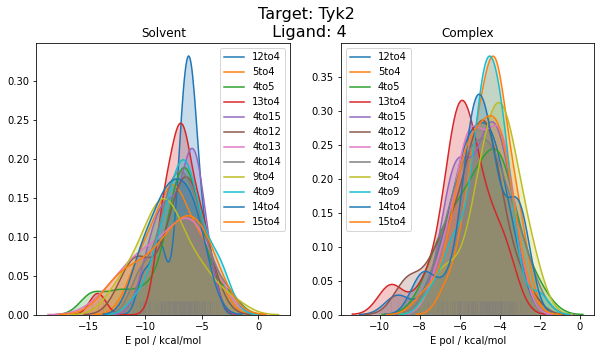

5
Correction is 3.54 (0.91) kcal/mol for ligand 5


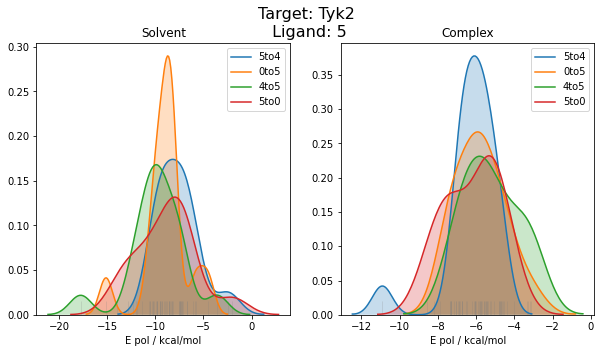

6
Correction is 3.82 (0.40) kcal/mol for ligand 6


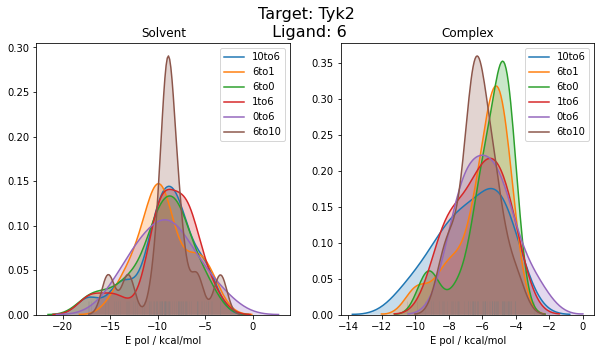

7
Correction is 4.28 (0.92) kcal/mol for ligand 7


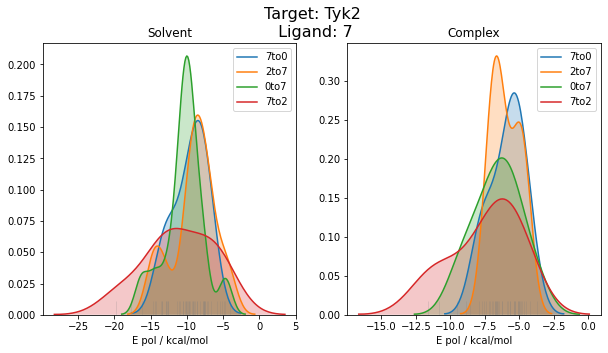

8
Correction is 3.24 (0.39) kcal/mol for ligand 8


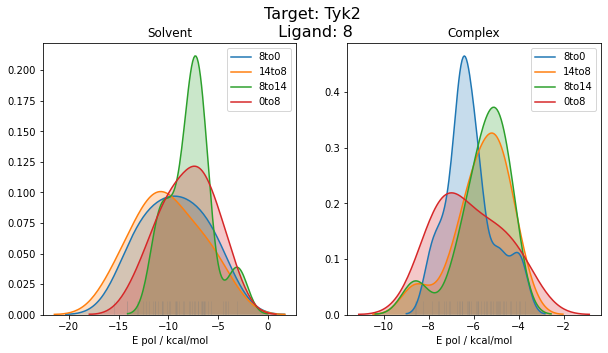

9
Correction is 2.86 (0.37) kcal/mol for ligand 9


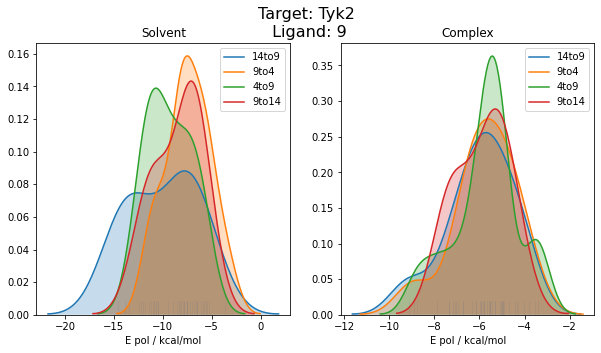

10
Correction is 3.77 (0.81) kcal/mol for ligand 10


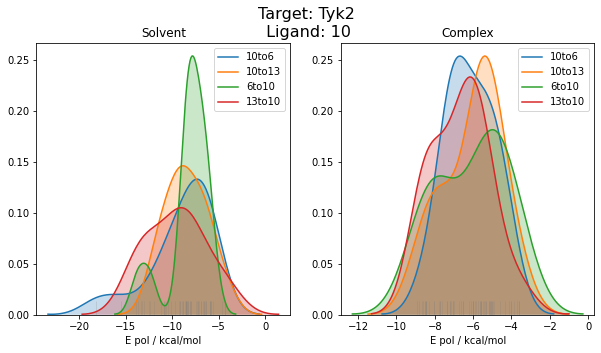

11
Correction is 2.98 (0.52) kcal/mol for ligand 11


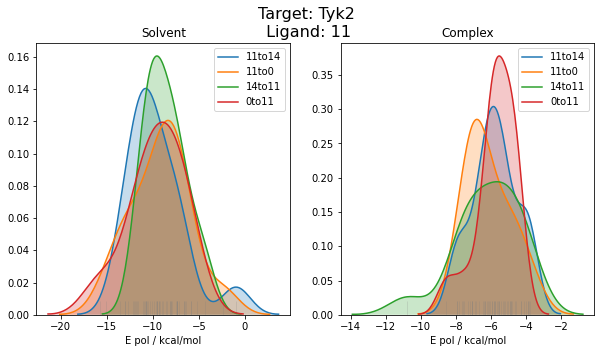

12
Correction is 4.79 (1.09) kcal/mol for ligand 12


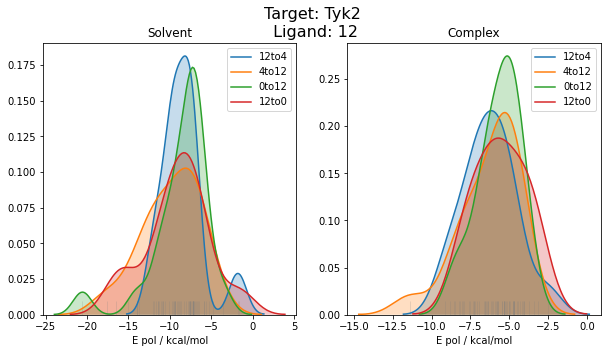

13
Correction is 3.37 (0.53) kcal/mol for ligand 13


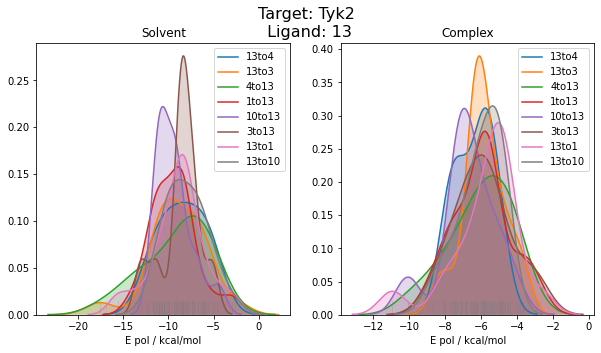

14
Correction is 5.62 (0.99) kcal/mol for ligand 14


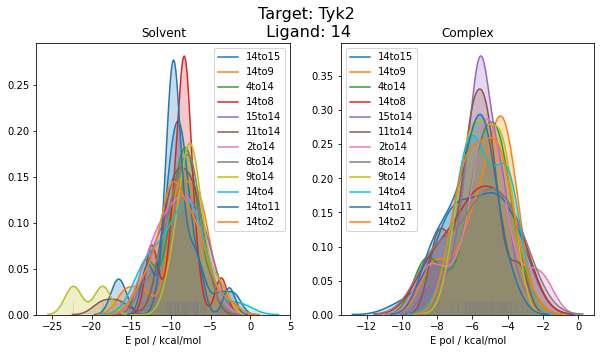

15
Correction is 4.96 (1.76) kcal/mol for ligand 15


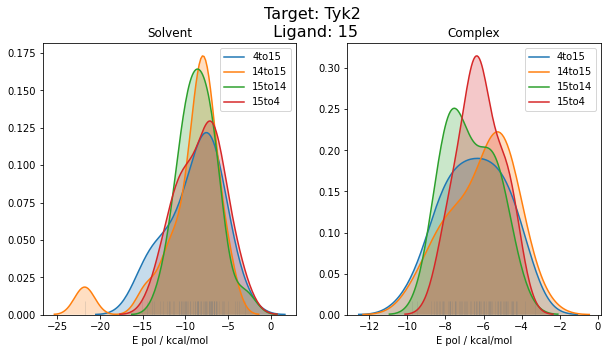

0
Correction is 2.56 (0.55) kcal/mol for ligand 0


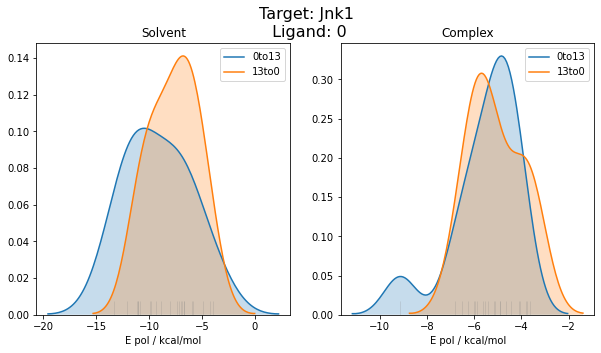

1
Correction is 3.54 (0.84) kcal/mol for ligand 1


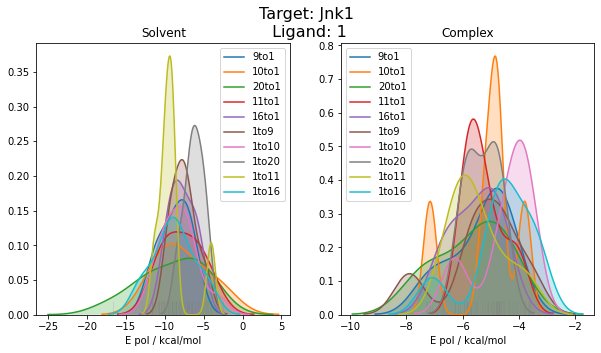

2
Correction is 3.30 (0.46) kcal/mol for ligand 2


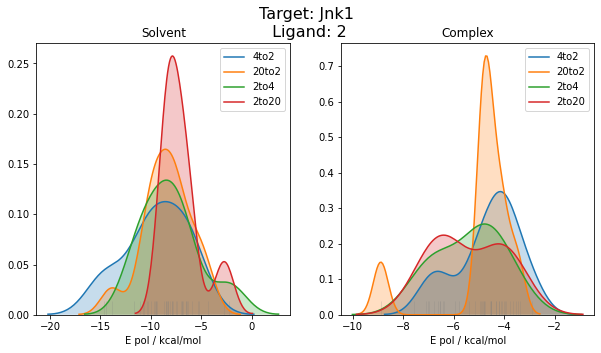

3
Correction is 2.93 (0.50) kcal/mol for ligand 3


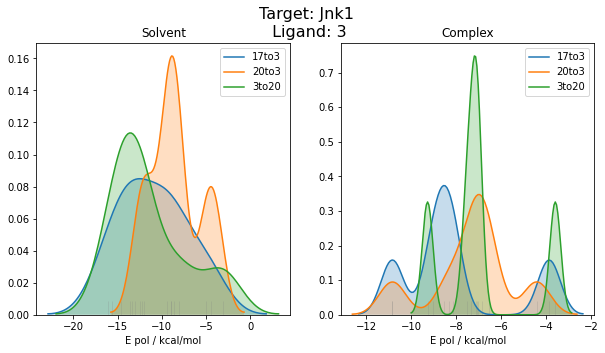

4
Correction is 2.55 (0.41) kcal/mol for ligand 4


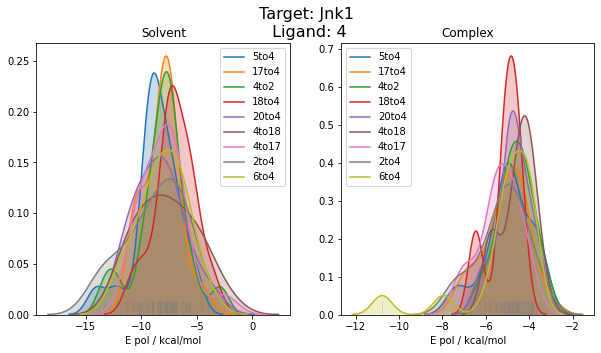

5
Correction is 5.27 (1.68) kcal/mol for ligand 5


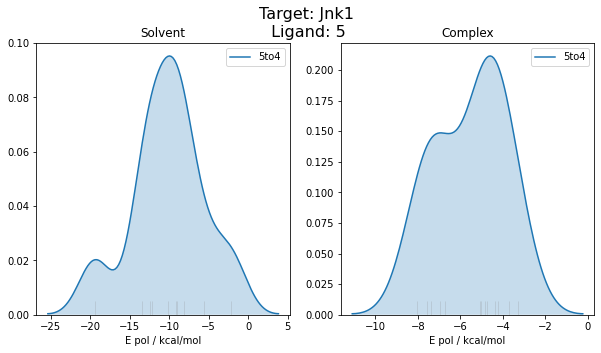

6
Correction is 2.44 (0.35) kcal/mol for ligand 6


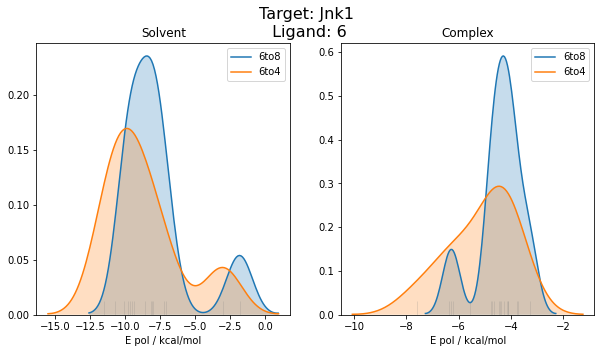

8
Correction is 3.42 (1.42) kcal/mol for ligand 8


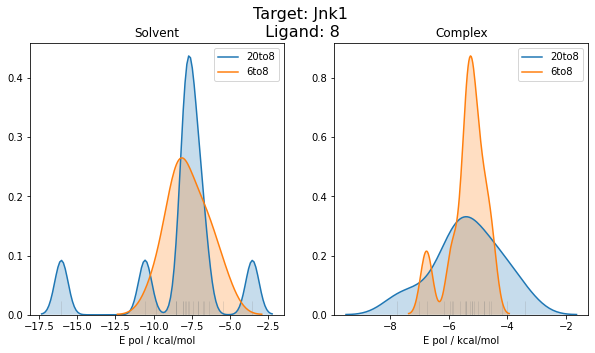

9
Correction is 3.46 (0.53) kcal/mol for ligand 9


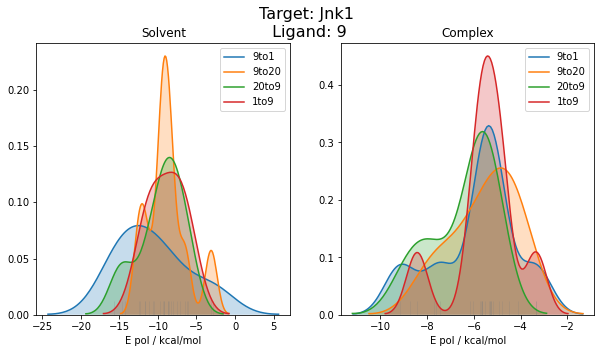

10
Correction is 4.69 (1.23) kcal/mol for ligand 10


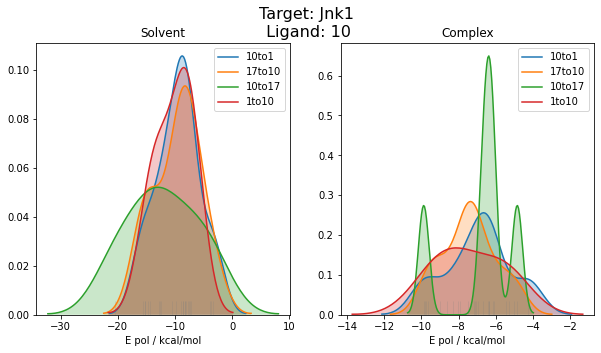

11
Correction is 2.77 (0.61) kcal/mol for ligand 11


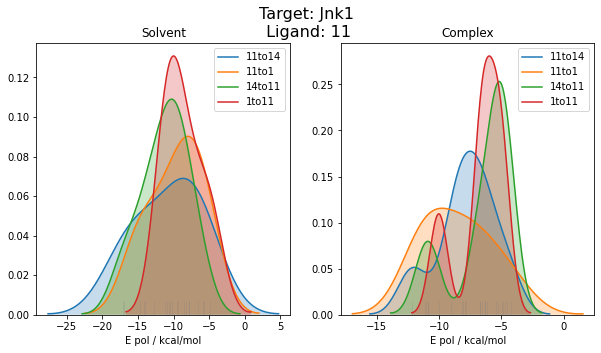

12
Correction is 3.98 (0.36) kcal/mol for ligand 12


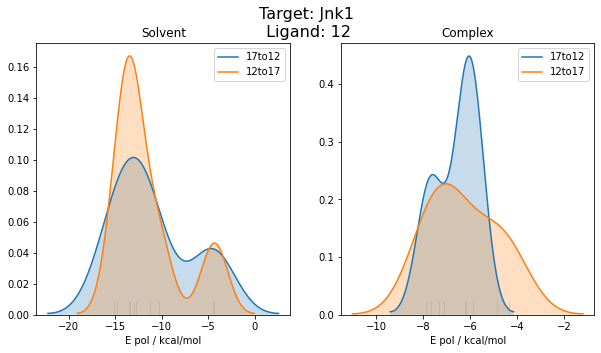

13
Correction is 2.81 (0.29) kcal/mol for ligand 13


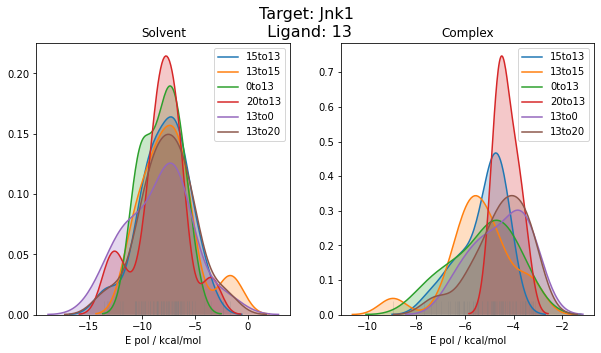

14
Correction is 3.46 (0.69) kcal/mol for ligand 14


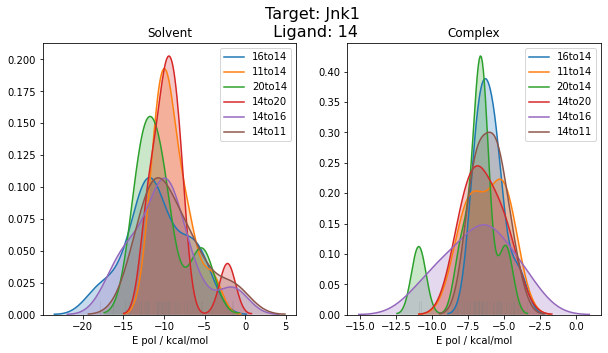

15
Correction is 3.89 (0.42) kcal/mol for ligand 15


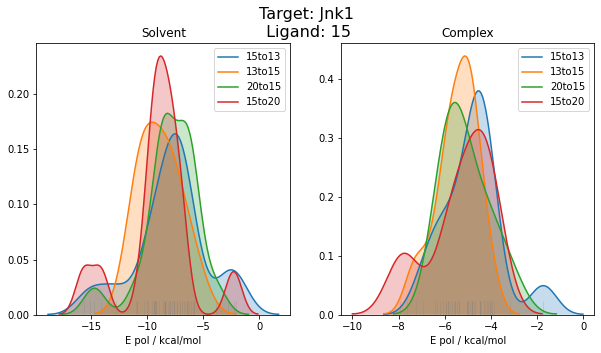

16
Correction is 4.04 (1.19) kcal/mol for ligand 16


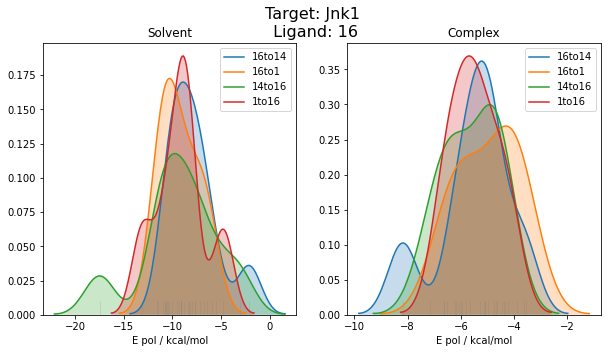

17
Correction is 3.03 (0.47) kcal/mol for ligand 17


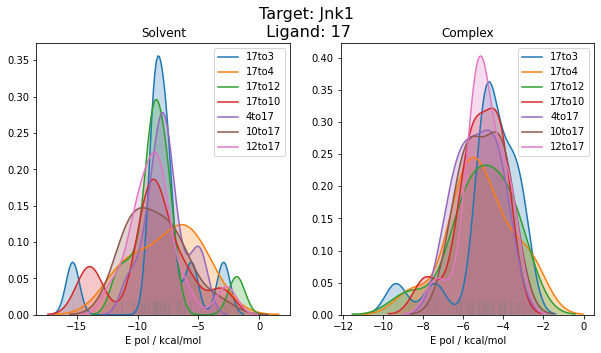

18
Correction is 4.57 (1.38) kcal/mol for ligand 18


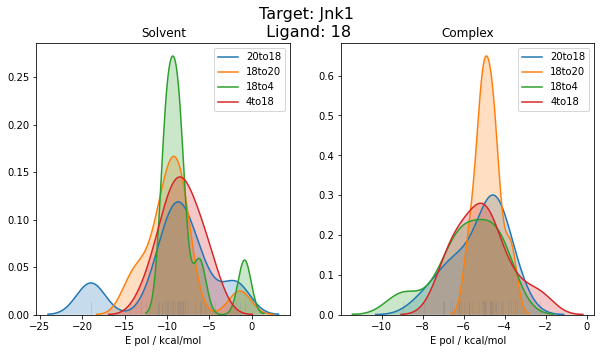

20
Correction is 4.25 (0.79) kcal/mol for ligand 20


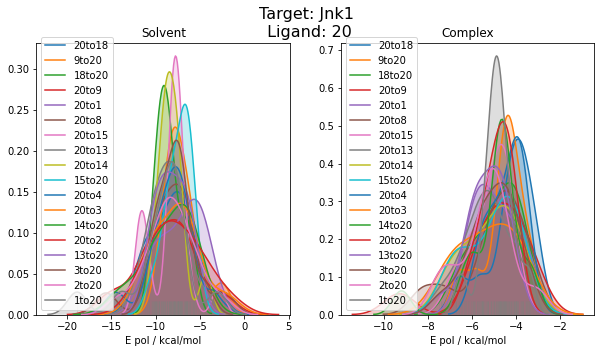

In [10]:
for c, target in enumerate(systems):

    color = sns.color_palette("hls", len(systems))[c]
    for ligand in new_better_results[target].keys():
        if len(new_better_results[target][ligand]) > 0:
            new_solvent_for_lig = []
            new_complex_for_lig = []
            fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(10,5))
            for thing in new_better_results[target][ligand]:
                if 'solvent' in thing:
                    Epol = new_better_results[target][ligand][thing]
                    sns.kdeplot(Epol,label=thing.split('-lig')[1],shade=True,ax=axes[0])
                    sns.rugplot(Epol,ax=axes[0],alpha=0.2,color='grey')
                    new_solvent_for_lig.extend(Epol)
                elif 'complex' in thing:
                    Epol = new_better_results[target][ligand][thing]
                    sns.kdeplot(Epol,label=thing.split('-lig')[1],shade=True,ax=axes[1])
                    sns.rugplot(Epol,ax=axes[1],alpha=0.2,color='grey')
                    new_complex_for_lig.extend(Epol)

            if len(new_solvent_for_lig) > 0 and len(new_complex_for_lig) > 0:
                bootstraps = []

                for _ in range(n_bootstrap):
                    comp = random.choices(new_complex_for_lig, k=len(new_complex_for_lig))
                    sol = random.choices(new_solvent_for_lig, k=len(new_solvent_for_lig))
                    corr_comp, err_comp = EXP(np.asarray(comp))
                    corr_sol, err_sol = EXP(np.asarray(sol))
                    bootstraps.append((corr_comp - corr_sol)*0.593)
                print(f'Correction is {np.mean(bootstraps):.2f} ({np.std(bootstraps):.2f}) kcal/mol for ligand {ligand}')
                all_better_corrections[target][ligand] = (np.mean(bootstraps), np.std(bootstraps))
            axes[0].set_title('Solvent')
            axes[1].set_title('Complex')
            axes[0].set_xlabel('E pol / kcal/mol')
            axes[1].set_xlabel('E pol / kcal/mol')
            fig.suptitle(f"Target: {target.capitalize()}\n Ligand: {ligand}", fontsize=16)
            plt.show()

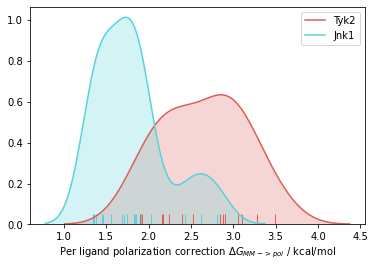

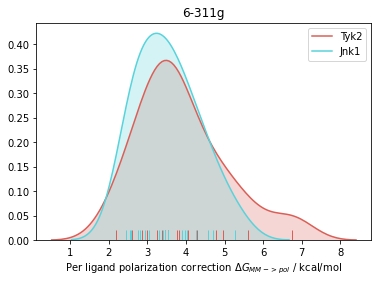

In [13]:
for c, target in enumerate(systems):
    color = sns.color_palette("hls", len(systems))[c]
    sns.kdeplot([i[0] for i in all_corrections[target].values()],label=target.capitalize(),shade=True,color=color)
    sns.rugplot([i[0] for i in all_corrections[target].values()],color=color)

plt.xlabel('Per ligand polarization correction $\Delta G_{MM->pol}$ / kcal/mol')
plt.legend()
plt.show()

for c, target in enumerate(systems):
    color = sns.color_palette("hls", len(systems))[c]
    sns.kdeplot([i[0] for i in all_better_corrections[target].values()],label=target.capitalize(),shade=True,color=color)
    sns.rugplot([i[0] for i in all_better_corrections[target].values()],color=color)

plt.xlabel('Per ligand polarization correction $\Delta G_{MM->pol}$ / kcal/mol')
plt.legend()
plt.title('6-311g')
plt.show()

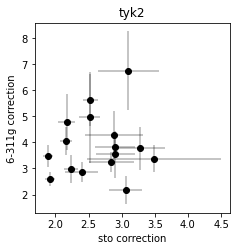

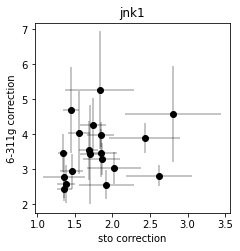

In [24]:
for target in all_corrections.keys():
    plt.figure(figsize=(3.5,3.5))
    for lig in all_corrections[target].keys():
        plt.scatter(all_corrections[target][lig][0],all_better_corrections[target][lig][0],color='k')
        plt.errorbar(all_corrections[target][lig][0],all_better_corrections[target][lig][0],xerr=all_corrections[target][lig][1],yerr=all_better_corrections[target][lig][1],color='k',alpha=0.3)
    plt.xlabel('sto correction')
    plt.ylabel('6-311g correction')
    plt.title(target)
    plt.show()

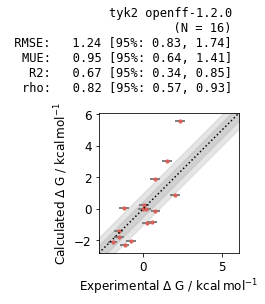

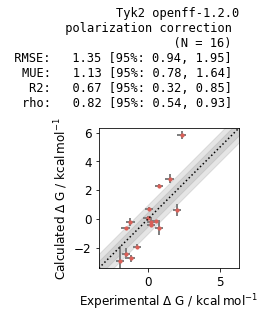

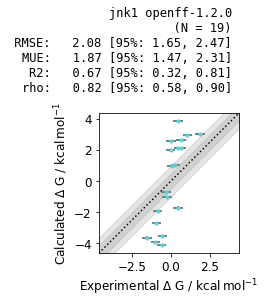

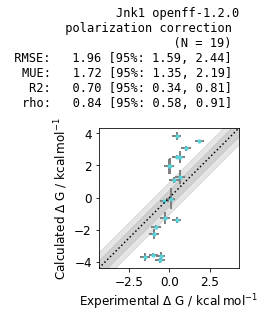

In [36]:
all_experimental = {'tyk2':[-9.540000 ,-10.940000 , -8.980000 , -11.310000 , -9.210000 , -8.260000 , -10.980000 , -7.750000 , -9.560000 , -7.420000 , -11.280000 , -9 , -9.700000 , -11.700000 , -9.780000 , -10.530000],
                'thrombin':[-8.46 ,-8.25 ,-7.86 ,-7.48 ,-9.18 ,-8.22 ,-8.32 ,-7.58 ,-8.89 ,-8.91 ,-8.56],
                'mcl1':[-8.235840 ,-6.662619 ,-6.875244 ,-7.601134 ,-8.812646 ,-7.919517 ,-9.225852 ,-7.689612 ,-6.583017 ,-7.019008 ,-8.448465 ,-9.328297     ,-6.621490 ,-8.431671 ,-7.026800 ,-8.953565 ,-7.853212 ,-9.779976 ,-8.673381 ,-8.828544 ,-6.939406 ,-7.253025 ,-7.955657 ,-8.079437 ,-8.361457 ,-9.499793 ,-7.129245 ,-8.407336 ,-9.407899 ,-9.062252 ,-6.116391 ,-5.775532 ,-9.038871 ,-9.258083 ,-9.964869 ,-8.179023 ,-8.915091 ,-8.953565 ,-8.896747 ,-7.580925 ,-6.869192 ,-7.034696],
                'jnk1':[-8.67377 ,-9.993231 ,-8.702592 ,-8.702592 ,-8.49337 ,-9.174299 ,-7.286071 ,-9.675922 ,-8.105004 ,-9.465222 ,-10.141692 ,-10.093111 ,-10.682977 ,-8.483096 ,-9.699398 ,-9.142359 ,-9.740725 ,-9.413821 ,-9.083236 ,-7.512318 ,-8.872536],
                'yeats':[0.3910271206921287, 0.0, 0.997215687216823, 1.1721953232170843, 0.8348342753027825, 0.3677170813347612, 0.08621554105016042, -0.25476098280047293, 0.22432463260984756, -0.19346226381792672, 0.5422560745018836, 0.8348342753027825, 0.7104307897669956, 0.08621554105016042, -0.28407677547204635, -0.667153285358724, -0.7083890758223867, -0.8900966006377791, -0.09881974150332055]
                 ,'cdk2':[-9.812000 ,-11.112000 ,-9.785000 ,-9.741000 ,-9.750000 ,-9.083000 ,-9.882000 ,-7.669000 ,-7.828000 ,-8.431000 ,-11.246000 ,-9.539000 ,-8.718000 ,-7.862000 ,-7.041000 ,-8.179000]
                   }
import networkx as nx
from arsenic import plotting, stats
import copy

for c,target in enumerate(systems):
    color = sns.color_palette("hls", len(systems))[c]
    mm_g = nx.OrderedDiGraph()

    experimental = all_experimental[target]
    
    for sim in all_mm[target]:
        ligA = int(sim.directory[3:].split('to')[0])
        ligB = int(sim.directory[3:].split('to')[1])
        mm_g.add_edge(ligA, ligB,calc_DDG=-sim.bindingdg/sim.bindingdg.unit, calc_dDDG=sim.bindingddg/sim.bindingddg.unit,exp_DDG=(experimental[ligB] - experimental[ligA]),exp_dDDG=0.1)
        
#     plotting.plot_DDGs(mm_g,title=f'{target} openff-1.2.0 RAW',color=color)
        
    f_i_calc, C_calc = stats.mle(mm_g, factor='calc_DDG')
    
    variance = np.diagonal(C_calc)
    for node, f_i, df_i in zip(mm_g.nodes(data=True), f_i_calc, variance**0.5):
        node[1]['calc_DG'] = f_i
        node[1]['calc_dDG'] = df_i
        node[1]['exp_DG'] = experimental[node[0]]
        node[1]['exp_dDG'] = 0.3    
    for edge in mm_g.edges(data=True):
        edge[2]['calc_DDG'] = mm_g.nodes[edge[1]]['calc_DG'] - mm_g.nodes[edge[0]]['calc_DG']
        edge[2]['calc_dDDG'] = (mm_g.nodes[edge[1]]['calc_dDG']**2 + mm_g.nodes[edge[0]]['calc_dDG']**2)**0.5
#     plotting.plot_DDGs(mm_g,title=f'{target} openff-1.2.0 MLE',color=color)
    plotting.plot_DGs(mm_g,title=f'{target} openff-1.2.0',color=color)

    pol_g = copy.deepcopy(mm_g)

    for node in pol_g.nodes(data=True):
        try:
            node[1]['calc_DG'] =  node[1]['calc_DG'] - all_corrections[target][node[0]][0]
            node[1]['calc_dDG'] =  (node[1]['calc_dDG']**2 + all_corrections[target][node[0]][1]**2)**0.5 
        except:
            print(f'No correction for {target} ligand {node[0]}')
            
    for edge in pol_g.edges(data=True):
        edge[2]['calc_DDG'] = pol_g.nodes[edge[1]]['calc_DG'] - pol_g.nodes[edge[0]]['calc_DG']
        edge[2]['calc_dDDG'] = (pol_g.nodes[edge[1]]['calc_dDG']**2 + pol_g.nodes[edge[0]]['calc_dDG']**2)**0.5
#     plotting.plot_DDGs(pol_g,title=f'{target} openff-1.2.0\n polarization correction',color=color)

    plotting.plot_DGs(pol_g,title=f'{target.capitalize()} openff-1.2.0\n polarization correction',color=color)

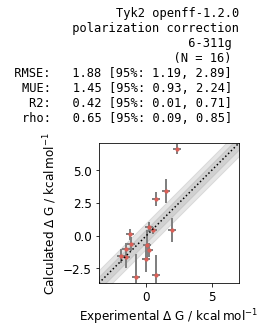

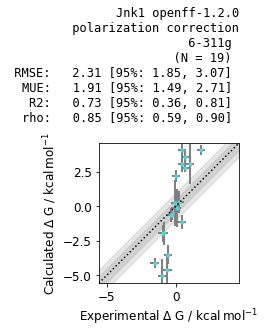

In [40]:
all_experimental = {'tyk2':[-9.540000 ,-10.940000 , -8.980000 , -11.310000 , -9.210000 , -8.260000 , -10.980000 , -7.750000 , -9.560000 , -7.420000 , -11.280000 , -9 , -9.700000 , -11.700000 , -9.780000 , -10.530000],
                'thrombin':[-8.46 ,-8.25 ,-7.86 ,-7.48 ,-9.18 ,-8.22 ,-8.32 ,-7.58 ,-8.89 ,-8.91 ,-8.56],
                'mcl1':[-8.235840 ,-6.662619 ,-6.875244 ,-7.601134 ,-8.812646 ,-7.919517 ,-9.225852 ,-7.689612 ,-6.583017 ,-7.019008 ,-8.448465 ,-9.328297     ,-6.621490 ,-8.431671 ,-7.026800 ,-8.953565 ,-7.853212 ,-9.779976 ,-8.673381 ,-8.828544 ,-6.939406 ,-7.253025 ,-7.955657 ,-8.079437 ,-8.361457 ,-9.499793 ,-7.129245 ,-8.407336 ,-9.407899 ,-9.062252 ,-6.116391 ,-5.775532 ,-9.038871 ,-9.258083 ,-9.964869 ,-8.179023 ,-8.915091 ,-8.953565 ,-8.896747 ,-7.580925 ,-6.869192 ,-7.034696],
                'jnk1':[-8.67377 ,-9.993231 ,-8.702592 ,-8.702592 ,-8.49337 ,-9.174299 ,-7.286071 ,-9.675922 ,-8.105004 ,-9.465222 ,-10.141692 ,-10.093111 ,-10.682977 ,-8.483096 ,-9.699398 ,-9.142359 ,-9.740725 ,-9.413821 ,-9.083236 ,-7.512318 ,-8.872536],
                'yeats':[0.3910271206921287, 0.0, 0.997215687216823, 1.1721953232170843, 0.8348342753027825, 0.3677170813347612, 0.08621554105016042, -0.25476098280047293, 0.22432463260984756, -0.19346226381792672, 0.5422560745018836, 0.8348342753027825, 0.7104307897669956, 0.08621554105016042, -0.28407677547204635, -0.667153285358724, -0.7083890758223867, -0.8900966006377791, -0.09881974150332055]
                 ,'cdk2':[-9.812000 ,-11.112000 ,-9.785000 ,-9.741000 ,-9.750000 ,-9.083000 ,-9.882000 ,-7.669000 ,-7.828000 ,-8.431000 ,-11.246000 ,-9.539000 ,-8.718000 ,-7.862000 ,-7.041000 ,-8.179000]
                   }
import networkx as nx
from arsenic import plotting, stats
import copy

for c,target in enumerate(systems):
    color = sns.color_palette("hls", len(systems))[c]
    mm_g = nx.OrderedDiGraph()

    experimental = all_experimental[target]
    
    for sim in all_mm[target]:
        ligA = int(sim.directory[3:].split('to')[0])
        ligB = int(sim.directory[3:].split('to')[1])
        mm_g.add_edge(ligA, ligB,calc_DDG=-sim.bindingdg/sim.bindingdg.unit, calc_dDDG=sim.bindingddg/sim.bindingddg.unit,exp_DDG=(experimental[ligB] - experimental[ligA]),exp_dDDG=0.1)
        
#     plotting.plot_DDGs(mm_g,title=f'{target} openff-1.2.0 RAW',color=color)
        
    f_i_calc, C_calc = stats.mle(mm_g, factor='calc_DDG')
    
    variance = np.diagonal(C_calc)
    for node, f_i, df_i in zip(mm_g.nodes(data=True), f_i_calc, variance**0.5):
        node[1]['calc_DG'] = f_i
        node[1]['calc_dDG'] = df_i
        node[1]['exp_DG'] = experimental[node[0]]
        node[1]['exp_dDG'] = 0.3    
    for edge in mm_g.edges(data=True):
        edge[2]['calc_DDG'] = mm_g.nodes[edge[1]]['calc_DG'] - mm_g.nodes[edge[0]]['calc_DG']
        edge[2]['calc_dDDG'] = (mm_g.nodes[edge[1]]['calc_dDG']**2 + mm_g.nodes[edge[0]]['calc_dDG']**2)**0.5
#     plotting.plot_DDGs(mm_g,title=f'{target} openff-1.2.0 MLE',color=color)
#     plotting.plot_DGs(mm_g,title=f'{target} openff-1.2.0',color=color)

    pol_g = copy.deepcopy(mm_g)

    for node in pol_g.nodes(data=True):
        try:
            node[1]['calc_DG'] =  node[1]['calc_DG'] - all_better_corrections[target][node[0]][0]
            node[1]['calc_dDG'] =  (node[1]['calc_dDG']**2 + all_better_corrections[target][node[0]][1]**2)**0.5 
        except:
            print(f'No correction for {target} ligand {node[0]}')
            
    for edge in pol_g.edges(data=True):
        edge[2]['calc_DDG'] = pol_g.nodes[edge[1]]['calc_DG'] - pol_g.nodes[edge[0]]['calc_DG']
        edge[2]['calc_dDDG'] = (pol_g.nodes[edge[1]]['calc_dDG']**2 + pol_g.nodes[edge[0]]['calc_dDG']**2)**0.5
#     plotting.plot_DDGs(pol_g,title=f'{target} openff-1.2.0\n polarization correction',color=color)

    plotting.plot_DGs(pol_g,title=f'{target.capitalize()} openff-1.2.0\n polarization correction\n 6-311g',color=color)

In [ ]:
# ax = {'solvent':0, 'complex':1}


# fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(10,5),sharey=True)
# phase = 'solvent'
# directory = 'lig0to12'

# # if str(ligand) == thing.split('to')[1]:
# #     state = 'new'
# # else:
# #     state = 'old'

# state = 'old'

# topology = md.load(f'../tyk2/off100/{directory}/{state}_{phase}.pdb').topology
# t = md.load(f'../tyk2/off100/{directory}/{state}_{phase}_aligned.dcd', top=topology)

# print(topology)
# print(t)
# ligand_ids = []
# ions_ids = []
# for r in topology.residues:
#     if r.name == 'MOL': 
#         for a in r.atoms:
#             ligand_ids.append(a.index)
#     if r.name == 'NA': 
#           for a in r.atoms:
#             ions_ids.append(a.index)

# comparisons = [[i,j] for i in ligand_ids for j in ions_ids]
# ion_dist = md.compute_distances(t,comparisons)

# closest_ion = np.min(ion_dist,axis=1)

# sns.regplot(10*closest_ion[1:],new_results[target][0][f'{phase}-{directory}']['Epol']*hartree_to_kT,ax=axes[ax[phase]],label=directory)

# axes[0].set_xlabel('Distance between ligand and closest Na+ / A')
# axes[0].set_ylabel('E pol / kT')
# axes[0].legend()
# axes[1].set_xlabel('Distance between ligand and closest Na+ / A')
# axes[1].set_ylabel('E pol / kT')
# axes[1].legend()
# fig.suptitle(f"Ligand {ligand} E-polarisation", fontsize=16)
# plt.show()

In [ ]:
t4_files = os.listdir('../T4lys/')

# print(t4_files)
t4_files = [x for x in t4_files if 'T4_Lysozyme_solv_epol' not in x]

colors= ['hotpink', 'purple', 'lightgreen']
t4_results = {}
for color, file in zip(colors, t4_files):
    molecule = file[22:-14]
    qmmm = []
    solv = []
    qmmm_solv = []
#     print(molecule)
    print(file)
    with open(f'../T4lys/{file}','r') as f:
        for line in f:
            print(line)
            qmmm.append(float(line.split()[7]))
            solv.append(float(line.split()[8]))
            qmmm_solv.append(float(line.split()[9]))
    t4_results[molecule] = {'qmmm': qmmm, 'solv':solv, 'qmmm_solv':qmmm_solv}

In [ ]:
bins = np.linspace(-4.,0.,81)

for mol, res in t4_results.items():
    plt.title(mol)
    plt.hist(res['qmmm_solv'],bins=bins)
    plt.hist(res['solv'],bins=bins)
    plt.show()
    epol_bound = res['qmmm_solv']
    epol_sol = res['solv']
    bootstraps = []
    for _ in range(n_bootstrap):
        comp = random.choices(epol_bound, k=len(epol_bound))
        sol = random.choices(epol_sol, k=len(epol_sol))
        corr_comp, err_comp = EXP(np.asarray(comp))
        corr_sol, err_sol = EXP(np.asarray(sol))
        bootstraps.append((corr_comp - corr_sol)*0.593)
    print(f'Correction is {np.mean(bootstraps):.2f} ({np.std(bootstraps):.2f}) kcal/mol')

In [ ]:
### HERE


files = [x for x in t4_files if 'Bound.dat' in x]
print(files)


for file in files:
    molecule = file[22:-14]
    epol_bound = []
    with open(f'../T4lys/{file}','r') as f:
        for line in f:
            epol_bound.append(float(line.split()[-1]))

    file = file.replace('Bound','Solv')
    molecule = file[22:-14]
    epol_sol = []
    with open(f'../T4lys/{file}','r') as f:
        for line in f:
            epol_sol.append(float(line.split()[-1]))


#     bins = np.linspace(-4.,0.,81)
    print(len(epol_bound))
    print(len(epol_sol))
    plt.hist(epol_bound,bins=100,label='complex',alpha=0.3)
    plt.hist(epol_sol,bins=100,label='solvent',alpha=0.3)
    plt.title(file[11:-9])
    plt.legend()
    plt.show()

    bootstraps = []
    for _ in range(n_bootstrap):
        comp = random.choices(epol_bound, k=len(epol_bound))
        sol = random.choices(epol_sol, k=len(epol_sol))
        corr_comp, err_comp = EXP(np.asarray(comp))
        corr_sol, err_sol = EXP(np.asarray(sol))
        bootstraps.append((corr_comp - corr_sol)*0.593)
    print(f'Correction is {np.mean(bootstraps):.2f} ({np.std(bootstraps):.2f}) kcal/mol')

In [ ]:

file = 'T4_Lysozyme_solv_epol_1MP.dat'
molecule = file[22:-14]
epol_bound = []
with open(f'../T4lys/{file}','r') as f:
    for line in f:
        epol_bound.append(float(line.split()[-1]))

file = 'T4_Lysozyme_solv_epol_1MP_Solv.dat'
molecule = file[22:-14]
epol_sol = []
with open(f'../T4lys/{file}','r') as f:
    for line in f:
        epol_sol.append(float(line.split()[-1]))


# file = 'T4_LysozymeS_solv_epol_1MP_Solv.dat'
plt.hist(epol_bound,bins=100,label='complex',alpha=0.3)
plt.hist(epol_sol,bins=100,label='solvent',alpha=0.3)
plt.title('1-methyl pyrrole')
plt.legend()
plt.show()

bootstraps = []
for _ in range(n_bootstrap):
    comp = random.choices(epol_bound, k=len(epol_bound))
    sol = random.choices(epol_sol, k=len(epol_sol))
    corr_comp, err_comp = EXP(np.asarray(comp))
    corr_sol, err_sol = EXP(np.asarray(sol))
    bootstraps.append((corr_comp - corr_sol)*0.593)
print(f'Correction is {np.mean(bootstraps):.2f} ({np.std(bootstraps):.2f}) kcal/mol')

In [ ]:
plt.scatter(epol_sol_un, epol_sol)

In [ ]:
systems = ['tyk2','jnk1']

all_corrections = {x: {} for x in systems}
all_mm = {x: [] for x in systems}
new_better_results = {x: {} for x in systems}
n_bootstrap = 1000
folders = ['off120-6-311']

plt.figure(figsize=(5,5))


for c, target in enumerate(systems):
    color = sns.color_palette("hls", len(systems))[c]

    for folder in folders:
        outputs = {}
        ligands = []
        for d in os.listdir(f'../{target}/{folder}/'):
            if d[-3:] == '.pi':
                results = np.load(f'../{target}/{folder}/{d}',allow_pickle=True) 
                all_mm[target].append(results)
            else:
                pair = tuple([int(i) for i in d[3:].split('to')])
                outputs[pair] = d
                ligands.append(pair[0])
                ligands.append(pair[1])

        ligands = set(ligands)
        new_better_results[target] = {i:{} for i in ligands}
        oldnew = {0:'old',1:'new'}
        for ligand in ligands:
            for output in outputs.keys():
                if ligand in output:
                    endstate = oldnew[output.index(ligand)]
                    all_solvent = []
                    all_complex = []
                    files = os.listdir(f'../{target}/{folder}/{outputs[output]}/')
                    files = [f for f in files if endstate in f and '-6-311g.npy' in f and 'solvent' in f]
                    for f in files:
                        solventfile = (f'../{target}/{folder}/{outputs[output]}/{f}')
                        if os.path.exists(solventfile):
                            solvent = np.load(solventfile,allow_pickle=True).flatten()[0]
                            val = solvent['Epol'][0]*hartree_to_kT*0.59
                            all_solvent.append(val)
                            index = int(f[11:-11])
                            plt.scatter(new_results[target][ligand][f'solvent-{outputs[output]}'][index],val,color='purple')
                    files = os.listdir(f'../{target}/{folder}/{outputs[output]}/')
                    files = [f for f in files if endstate in f and '-6-311g.npy' in f and 'complex' in f]
                    for f in files:
                        complexfile = (f'../{target}/{folder}/{outputs[output]}/{f}')
                        if os.path.exists(complexfile):
                            complex_ = np.load(complexfile,allow_pickle=True).flatten()[0]
                            val = complex_['Epol'][0]*hartree_to_kT*0.59
                            all_complex.append(val)    
                            index = int(f[11:-11])
                            plt.scatter(new_results[target][ligand][f'complex-{outputs[output]}'][index],val,color='hotpink')
                    if f'solvent-{outputs[output]}' not in new_better_results:
                        new_better_results[target][ligand][f'solvent-{outputs[output]}'] = []
                    if f'complex-{outputs[output]}' not in new_better_results:
                        new_better_results[target][ligand][f'complex-{outputs[output]}'] = []
                    print(outputs[output])
                    new_better_results[target][ligand][f'solvent-{outputs[output]}'].extend(all_solvent)
                    new_better_results[target][ligand][f'complex-{outputs[output]}'].extend(all_complex)

plt.xlabel('sto-3g Epol')
plt.ylabel('6-311g Epol')
plt.show()

In [ ]:
print(all_corrections)
print(all_better_corrections)

In [ ]:
print(new_better_results[target][ligand].keys())
print(new_results[target][ligand].keys())